# Dense network demonstrations

The ``torch_tools.DenseNetwork`` model can be used for classification or regression.

First, Let's use it for a classification problem.

* Some data:
    * For the classification and regression examples we will use some datasets available from scikit-learn.
    * We will also need to load the data using a ``Dataset`` and ``DataLoader``.
* A model:
    * We will instantiate the model shortly.
* A loss function.
* A optimiser to fit the model with.

## Classification example


Let us grab some data from scikit learn:

In [1]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer(as_frame=True).frame

valid_split = data.groupby("target").sample(frac=0.2, random_state=123)

train_split = data.loc[~data.index.isin(valid_split.index)]

print(train_split.shape)
print(valid_split.shape)

(456, 31)
(113, 31)


Now we have downloaded the breast cancer dataset from scikit-learn, and split the data into a training and validation set. Conventially, one should split the data into a training, validation and testing set, but since this is only a simple example to illustrate use of the model, we skip this formality.

As a matter of convenience, let's grab a list of the keys for accessing the data and targets separately.

In [2]:
data_keys = list(filter(lambda x: x != "target", data.keys()))
target_keys = ["target"]

Now, let's create a training and validation dataset.

In [3]:
from torch import eye
from torchvision.transforms import Compose

from torch_tools import DataSet

train_set = DataSet(
    inputs=tuple(train_split[data_keys].to_numpy()),
    targets=tuple(train_split[target_keys].to_numpy()),
    target_tfms=Compose([lambda x: eye(2)[x].squeeze()]),
)

valid_set = DataSet(
    inputs=tuple(valid_split[data_keys].to_numpy()),
    targets=tuple(valid_split[target_keys].to_numpy()),
    target_tfms=Compose([lambda x: eye(2)[x].squeeze()]),
)

# Let's grab an input and target from the validation set and see what we get.
x_item, y_item = valid_set[0]

print(x_item.shape)
print(y_item.shape)

(30,)
torch.Size([2])


PyTorch Datasets generally return single input-target pairs, but when training neural networks we normally stack inputs and targets in mini-batches. The PyTorch way to achieve this is use a ``DataLoader`` object.

In [4]:
from torch.utils.data import DataLoader

batch_size = 10

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_set, shuffle=False, batch_size=batch_size)

for batch, targets in valid_loader:
    print(batch.shape, targets.shape)

torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([3, 30]) torch.Size([3, 2])


Now we have the data, we need a model, loss function and optimiser. Let's set these things up.

In [5]:
from torch.nn import BCELoss
from torch.optim import Adam

from torch_tools import DenseNetwork


loss_func = BCELoss(reduction="sum")

model = DenseNetwork(
    in_feats=30,
    out_feats=2,
    hidden_sizes=(16, 8),
    input_dropout=0.1,
    input_bnorm=True,
    hidden_dropout=0.25,
)
print(model)


optimiser = Adam(model.parameters(), lr=1e-4)

DenseNetwork(
  (0): InputBlock(
    (0): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.1, inplace=False)
  )
  (1): DenseBlock(
    (0): Linear(in_features=30, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): LeakyReLU(negative_slope=0.1)
  )
  (2): DenseBlock(
    (0): Linear(in_features=16, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): LeakyReLU(negative_slope=0.1)
  )
  (3): DenseBlock(
    (0): Linear(in_features=8, out_features=2, bias=True)
  )
)


Let's write functions for training and validating single epochs

In [6]:
from torch.nn import Module
from torch import no_grad


def train_one_epoch(
    model: Module,
    loss_func: BCELoss,
    optim: Adam,
    train_loader: DataLoader,
):
    """Train the model for a single epoch.

    Parameters
    ----------
    model : Module
        The model we want to train.
    loss_func : BCELoss
        Binary-cross-entropy loss function.
    optim : Adam
        Adam optimiser.
    train_loader : DataLoader
        Training dataloader.

    Returns
    -------
    mean_loss: float
        Mean loss per batch.
    accuracy : float
        Accuracy over the epoch.

    """
    model.train()
    running_loss = 0.0
    correct = 0
    for batch, targets in train_loader:
        batch, targets = batch.float(), targets.float()

        optim.zero_grad()

        prediction = model(batch).softmax(dim=1)

        loss = loss_func(prediction, targets)

        loss.backward()

        optim.step()

        running_loss += loss.item()

        correct += (prediction.detach().argmax(dim=1) == targets.argmax(dim=1)).sum()

    mean_loss = running_loss / len(train_loader.dataset)
    accuracy = correct / len(train_loader.dataset)

    return mean_loss, accuracy


@no_grad()
def validate_one_epoch(
    model: Module,
    loss_func: BCELoss,
    valid_loader: DataLoader,
):
    """Validate single epoch.

    Parameters
    ----------
    model : Module
        The model to validate.
    loss_func : BCELoss
        Binary-cross-entropy loss function.
    valid_loader : DataLoader
        Validation data loader.
    
    Returns
    -------
    float
        Mean loss per item.
    accuracy : float
        Accuracy over the epoch.

    """
    model.eval()
    running_loss = 0.0
    correct = 0
    for batch, targets in valid_loader:
        batch, targets = batch.float(), targets.float()

        prediction = model(batch).softmax(dim=1)

        loss = loss_func(prediction, targets)

        correct += (prediction.argmax(dim=1) == targets.argmax(dim=1)).sum()

        running_loss += loss.item()

    mean_loss = running_loss / len(valid_loader.dataset)
    accuracy = correct / len(valid_loader.dataset)

    return mean_loss, accuracy

Now, we train!

In [7]:
metrics = {
    "train_loss": [],
    "valid_loss": [],
    "train_acc": [],
    "valid_acc": [],
}

for epoch in range(200):
    train_loss, train_acc = train_one_epoch(
        model,
        loss_func,
        optimiser,
        train_loader,
    )
    valid_loss, valid_acc = validate_one_epoch(model, loss_func, valid_loader)

    metrics["train_loss"].append(train_loss)
    metrics["train_acc"].append(train_acc)
    metrics["valid_loss"].append(valid_loss)
    metrics["valid_acc"].append(valid_acc)



Now that the model is trained, we can plot the ``metrics`` dictionary we have populated.

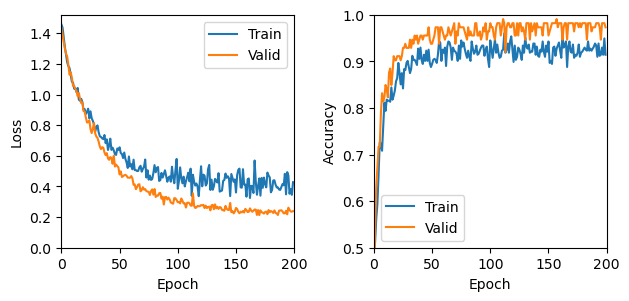

In [8]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(1, 2)
axes[0].plot(metrics["train_loss"], label="Train")
axes[0].plot(metrics["valid_loss"], label="Valid")


axes[1].plot(metrics["train_acc"], label="Train")
axes[1].plot(metrics["valid_acc"], label="Valid")

axes[0].set_ylim(bottom=0.0)
axes[1].set_ylim(bottom=0.5, top=1.0)

axes[0].set_ylabel("Loss")
axes[1].set_ylabel("Accuracy")


for axis in axes.ravel():
    axis.set_xlabel("Epoch")
    axis.set_xlim(left=0.0, right=len(metrics["train_acc"]))
    axis.set_aspect(
        (axis.get_xlim()[1] - axis.get_xlim()[0])
        / (axis.get_ylim()[1] - axis.get_ylim()[0])
    )
    axis.legend()


figure.tight_layout()

plt.show()

## Regression Example

In the classification example, we asked the model to produce a discrete classification by obtaining a prediction from the maximum argument of the softmax's output. In this case, we will use the diabetes dataset from scikit learn.

In this case there are ten classes, and the output is a continuous, quantative measure of disease.

In [9]:
from sklearn.datasets import load_diabetes

data = load_diabetes(as_frame=True, scaled=False).frame


valid_data = data.sample(frac=0.2, random_state=123)
train_data = data.loc[~data.index.isin(valid_data.index)]

print(valid_data.shape)
print(train_data.shape)


input_keys = list(filter(lambda x: x != "target", data.keys()))

print(input_keys)
print(target_keys)

(88, 11)
(354, 11)
['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
['target']


Now we can create our dataset and dataloader objects as we did before.

In [10]:
train_set = DataSet(
    inputs=tuple(train_data[input_keys].to_numpy()),
    targets=tuple(train_data[target_keys].to_numpy()),
)


valid_set = DataSet(
    inputs=tuple(valid_data[input_keys].to_numpy()),
    targets=tuple(valid_data[target_keys].to_numpy()),
)

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_set, shuffle=False, batch_size=batch_size)

for batch, target in valid_loader:
    print(batch.shape, target.shape)

torch.Size([10, 10]) torch.Size([10, 1])
torch.Size([10, 10]) torch.Size([10, 1])
torch.Size([10, 10]) torch.Size([10, 1])
torch.Size([10, 10]) torch.Size([10, 1])
torch.Size([10, 10]) torch.Size([10, 1])
torch.Size([10, 10]) torch.Size([10, 1])
torch.Size([10, 10]) torch.Size([10, 1])
torch.Size([10, 10]) torch.Size([10, 1])
torch.Size([8, 10]) torch.Size([8, 1])


In [11]:
model = DenseNetwork(
    in_feats=10,
    out_feats=1,
    hidden_sizes=(10, 10, 5, 5),
    input_bnorm=True,
    hidden_bnorm=True,
    input_dropout=0.1,
    hidden_dropout=0.25,
)
print(model)

DenseNetwork(
  (0): InputBlock(
    (0): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.1, inplace=False)
  )
  (1): DenseBlock(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): LeakyReLU(negative_slope=0.1)
  )
  (2): DenseBlock(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): LeakyReLU(negative_slope=0.1)
  )
  (3): DenseBlock(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): LeakyReLU(negative_slope=0.1)
  )
  (4): DenseBlock(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1)

We also need a new loss function: this time—means-squared-error.

In [12]:
from torch.nn import L1Loss

loss_func = L1Loss(reduction="sum")
optimiser = Adam(model.parameters(), lr=1e-4)

Now we need to rewrite the training and validation functions to extract slightly different information than we did in the classification example.

In [13]:
def train_one_epoch(
    model: Module,
    loss_func: L1Loss,
    optim: Adam,
    train_loader: DataLoader,
):
    """Train the regression model for a single epoch.

    Parameters
    ----------
    model : Module
        PyTorch model.
    loss_func : L1Loss
        The loss function.
    optim : Adam
        Optimiser to train the function with.
    train_loader : DataLoader
        Training dataloader.

    """
    model.train()
    running_loss = 0.0
    for batch, targets in train_loader:

        batch, targets = batch.float(), targets.float()

        optim.zero_grad()

        preds = model(batch)

        loss = loss_func(preds, targets)

        loss.backward()

        optim.step()

        running_loss += loss.item()

    return running_loss / len(train_loader.dataset)


@no_grad()
def validate_one_epoch(
    model: Module,
    loss_func: L1Loss,
    valid_loader: DataLoader,
):
    """Validate single epoch.
    
    Parameters
    ----------
    model : Module
        PyTorch model to validate.
    loss_func : L1Loss
        Mean-squared-error loss.
    valid_loader : DataLoader
        Validation DataLoader.
    
    Returns
    -------
    float
        Mean loss over the epoch.
    
    """
    model.eval()
    running_loss = 0.0
    for batch, targets in valid_loader:

        batch, targets = batch.float(), targets.float()

        pred = model(batch)

        loss = loss_func(pred, targets)

        running_loss += loss.item()
    
    return running_loss / len(valid_loader.dataset)

Now, let's train!

(0.0, 156.5576748052988)

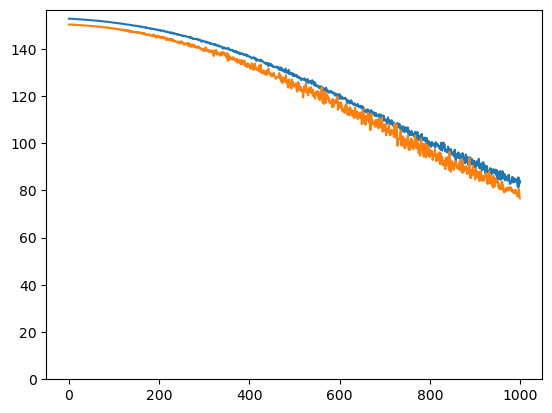

In [14]:
metrics = {"train_loss": [], "valid_loss": []}

for epoch in range(1000):

    train_loss = train_one_epoch(model, loss_func, optimiser, train_loader)
    valid_loss = validate_one_epoch(model, loss_func, valid_loader)

    metrics["train_loss"].append(train_loss)
    metrics["valid_loss"].append(valid_loss)


plt.plot(metrics["train_loss"])
plt.plot(metrics["valid_loss"])

plt.ylim(bottom=0.0)